In [1]:
import pandas as pd
import requests
import time
import hvplot.pandas
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json
from scipy.stats import linregress
from scipy import stats
from pathlib import Path
from amadeus import Client, ResponseError
from datetime import datetime, timedelta

from config import amadeus_api
from config import amadeus_sec

In [2]:
#Obtain Amedius token
amadeus = Client(client_id=amadeus_api, client_secret=amadeus_sec)


CHEAPEST FLIGHTS FOR THE MONTH OF DEC 2024 TRAVELLING FROM SYD TO LAX BY DIFFERENT AIRLINES

Data saved to flight_offers_SYD_to_LAX.csv


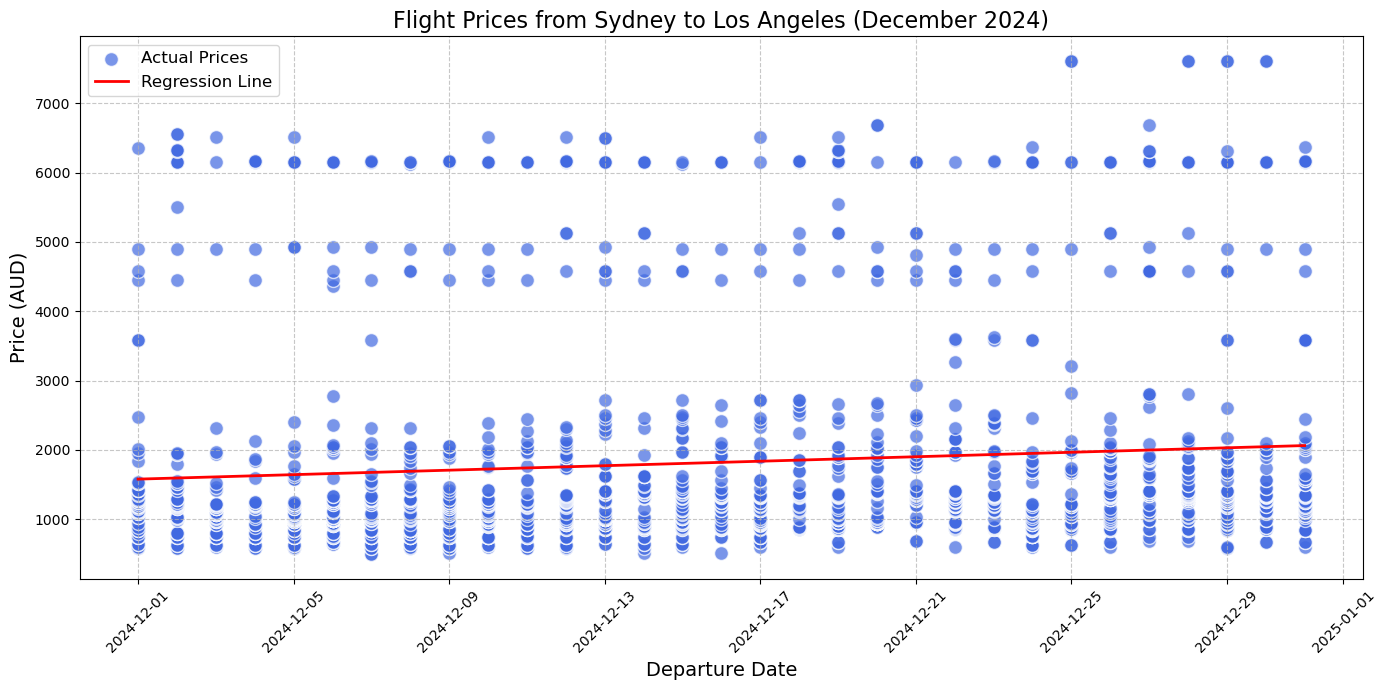

In [3]:

#Define parameters
origin_city = 'Sydney'
origin_code = 'SYD'
destination_city = 'Los Angeles'
destination_code = 'LAX'

# Function to generate all dates in December
def generate_december_dates(year):
    return [(datetime(year, 12, day)).strftime('%Y-%m-%d') for day in range(1, 32) if (datetime(year, 12, day).month == 12)]

# Generate December dates for 2024
departure_dates = generate_december_dates(2024)
flight_data_list = []

# Loop through each departure date in December
for departure_date in departure_dates:
    try:
        response = amadeus.shopping.flight_offers_search.get(
            originLocationCode=origin_code,
            destinationLocationCode=destination_code,
            departureDate=departure_date,
            adults=1
        )

        if response.data:
            flight_data = json.loads(response.body)
            for flight in flight_data["data"]:
                flight_info = {
                    'Departure Date': departure_date,
                    'Origin City': f"{origin_city} ({origin_code})",
                    'Destination City': f"{destination_city} ({destination_code})",
                    'Airline': flight['validatingAirlineCodes'][0],
                    'Price (AUD)': float(flight['price']['total'])  # Convert to float for plotting
                }
                flight_data_list.append(flight_info)
        else:
            print(f"No flights available for {departure_date}.")

    except ResponseError as error:
        print(f"An error occurred while fetching flight offers for {departure_date}: {error}")

# Create a DataFrame from the collected flight data
flight_data_df = pd.DataFrame(flight_data_list)

# Save to a CSV file
csv_filename = f'flight_offers_{origin_code}_to_{destination_code}.csv'
flight_data_df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

# Display the DataFrame 

flight_data_df.head()

# Prepare data for regression
flight_data_df['Departure Date'] = pd.to_datetime(flight_data_df['Departure Date'])
flight_data_df['Date Ordinal'] = flight_data_df['Departure Date'].apply(lambda x: x.toordinal())

X = flight_data_df['Date Ordinal']
y = flight_data_df['Price (AUD)']

# Perform linear regression using scipy.stats
slope, intercept, r_value, p_value, std_err = linregress(X, y)

# Calculate predicted prices
flight_data_df['Predicted Price'] = intercept + slope * X

# Create a scatter plot with regression line
plt.figure(figsize=(14, 7))
plt.scatter(flight_data_df['Departure Date'], flight_data_df['Price (AUD)'], 
            color='royalblue', label='Actual Prices', alpha=0.7, edgecolors='w', s=100)

# Plot regression line
plt.plot(flight_data_df['Departure Date'], flight_data_df['Predicted Price'], 
         color='red', linewidth=2, label='Regression Line')

# Customize the plot
plt.title('Flight Prices from Sydney to Los Angeles (December 2024)', fontsize=16)
plt.xlabel('Departure Date', fontsize=14)
plt.ylabel('Price (AUD)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('Flight_Prices_Sydney_to_LosAngeles_Dec2024.png', bbox_inches='tight')
plt.show()



Average Flight Prices by Airline:
   Airline  Price (AUD)
0       AC  1651.605000
1       BR  4903.283478
2       CA  1252.223333
3       CI  2097.985455
4       CX  1138.744255
5       CZ  5614.258889
6       EK  1999.088696
7       EY  2536.560000
8       FJ   946.245263
9       HA  1147.715257
10      KE  1156.233226
11      LA  2213.360526
12      MF   606.670000
13      MU  4567.775714
14      NH   951.763949
15      NZ  1593.558214
16      OZ   898.988462
17      PR   756.461290
18      QF  1552.641622
19      QR  1931.689722
20      TN   903.073250
21      UA  3630.520750


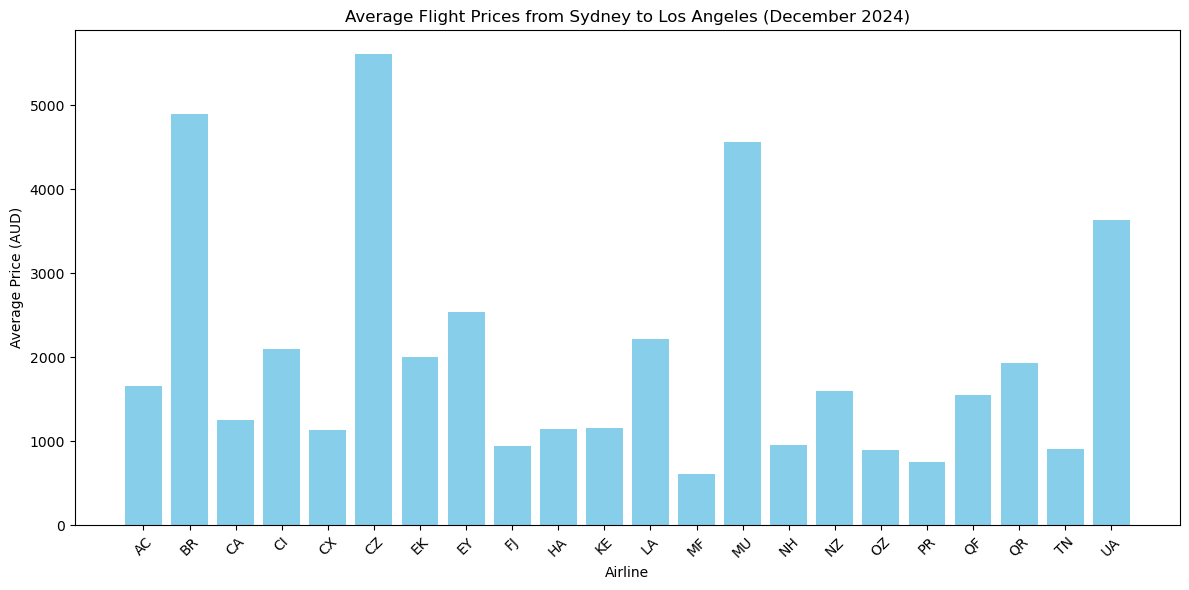

In [4]:
#AVERAGE FLIGHT CHARGES BY AIRLINE FROM SYDNEY TO LOS ANGELES IN DEC 2024

# Convert the 'Price (AUD)'
flight_data_df['Price (AUD)'] = pd.to_numeric(flight_data_df['Price (AUD)'], errors='coerce')

# Calculate average flight prices by airline
average_price_by_airline = flight_data_df.groupby('Airline')['Price (AUD)'].mean().reset_index()

# Print the average flight prices by airline
print("\nAverage Flight Prices by Airline:")
print(average_price_by_airline)

# Create a bar chart to visualize average flight prices by airline
plt.figure(figsize=(12, 6))
plt.bar(average_price_by_airline['Airline'], average_price_by_airline['Price (AUD)'], color='skyblue')

plt.title('Average Flight Prices from Sydney to Los Angeles (December 2024)')
plt.xlabel('Airline')
plt.ylabel('Average Price (AUD)')
plt.xticks(rotation=45)  
plt.tight_layout()  

# Save the plot as a PNG file
plt.savefig('Average_Flight_Prices_Dec24_By_Airline.png', bbox_inches='tight')  
plt.show()  


Chi-Square Test Analysis


Chi-Square Test Results:
Chi2 Statistic: 1420.57
P-value: 0.0000
Degrees of Freedom: 95
Reject the null hypothesis: There is a significant association between price ranges and airlines.


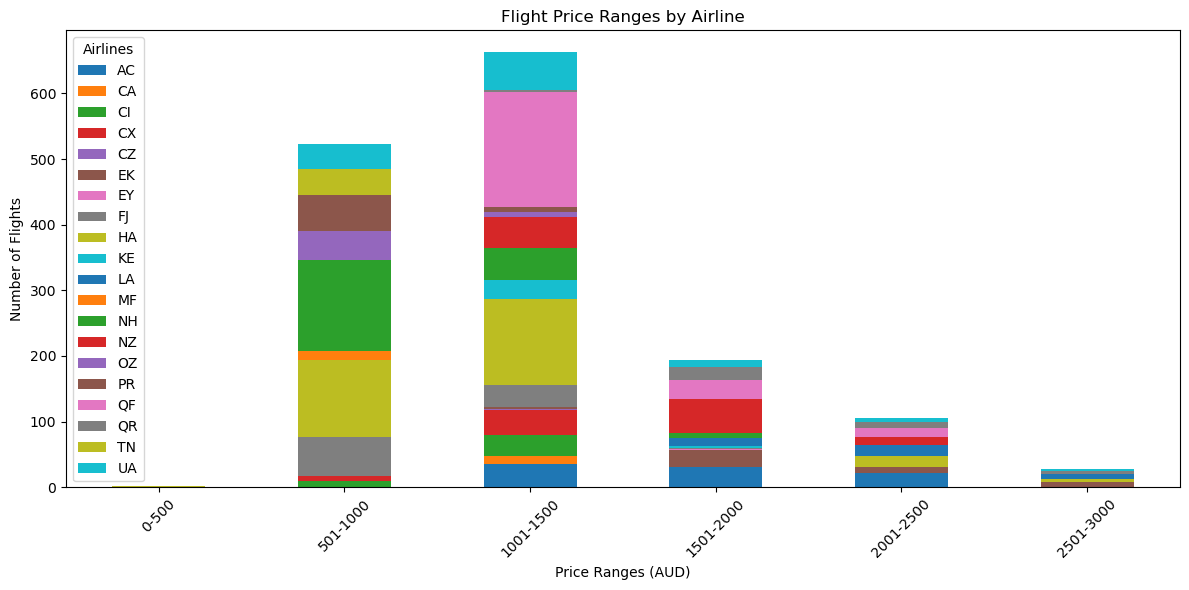

In [5]:
# Categorize price data into bins
price_bins = pd.cut(flight_data_df['Price (AUD)'], bins=[0, 500, 1000, 1500, 2000, 2500, 3000], 
                    labels=['0-500', '501-1000', '1001-1500', '1501-2000', '2001-2500', '2501-3000'])

# Create a Series for airline counts based on price ranges
airline_series = pd.Series(flight_data_df['Airline'])
contingency_table = pd.DataFrame({'Price Range': price_bins, 'Airline': airline_series})

# Create a contingency table
contingency_table = pd.crosstab(contingency_table['Price Range'], contingency_table['Airline'])

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print results
print("\nChi-Square Test Results:")
print(f"Chi2 Statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of Freedom: {dof}")


# Interpret the result
# significance level
alpha = 0.05  
if p < alpha:
    print("Reject the null hypothesis: There is a significant association between price ranges and airlines.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between price ranges and airlines.")

# Optional: Visualize the contingency table
contingency_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Flight Price Ranges by Airline')
plt.xlabel('Price Ranges (AUD)')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.legend(title='Airlines')
plt.tight_layout()
plt.savefig('Average_Flight_Price_Range_by_Airline.png', bbox_inches='tight') 
plt.show()

Data saved to Air_Traffic_Scores_LAX_2018.csv


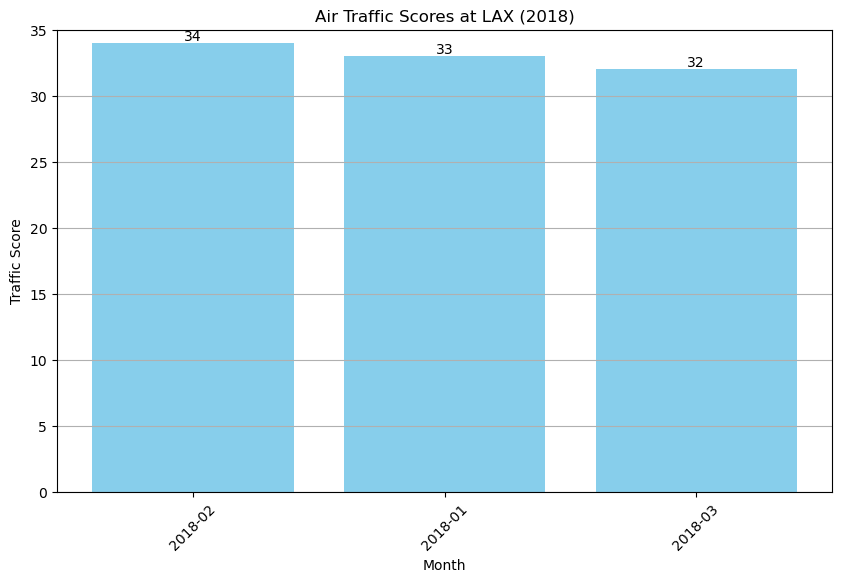

In [6]:

city_code = 'LAX'
direction = 'ARRIVING'
period = '2018'

try:
    response = amadeus.travel.analytics.air_traffic.busiest_period.get(
        cityCode=city_code, period=period, direction=direction)

    # Accessing the air traffic data
    air_traffic_data = response.data
    
    if air_traffic_data:
        # Prepare data for DataFrame
        months = []
        scores = []
        
        for entry in air_traffic_data:
            months.append(entry['period'])
            scores.append(entry['analytics']['travelers']['score'])
        
        # Create a DataFrame
        df = pd.DataFrame({
            'Month': months,
            'Traffic Score': scores
        })

        # Save to CSV file
        csv_filename = 'Air_Traffic_Scores_LAX_2018.csv'
        df.to_csv(csv_filename, index=False)
        print(f"Data saved to {csv_filename}")

        # Create the bar chart
        plt.figure(figsize=(10, 6))
        bars = plt.bar(df['Month'], df['Traffic Score'], color='skyblue')

        # Add titles and labels
        plt.title('Air Traffic Scores at LAX (2018)')
        plt.xlabel('Month')
        plt.ylabel('Traffic Score')
        plt.xticks(rotation=45)
        plt.ylim(0, max(df['Traffic Score']) + 1)
        plt.grid(axis='y')

        # Display the score on each bar
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), 
                     ha='center', va='bottom')  # Position the text above the bar

        # Save the plot as a PNG file
        plt.savefig('Air_Traffic_Scores_LAX_2018.png', bbox_inches='tight')
        plt.show()
    else:
        print("No data available for the specified period.")

except ResponseError as error:
    print(f"Error: {error.message} (Code: {error.code})")
